In [1]:
from qiskit import QuantumCircuit, Aer, execute,QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import standard_gates
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.transpiler.passes import RemoveFinalMeasurements
from mitiq.interface import convert_to_mitiq, convert_from_mitiq
import numpy as np
import math as math
import matplotlib.pyplot as plt

from mitiq import zne
from mitiq.zne.scaling.layer_scaling import layer_folding, get_layer_folding
from mitiq.interface.conversions import atomic_converter

import cirq
from cirq.contrib.qasm_import import circuit_from_qasm

In [2]:
global depolarNoise

In [3]:
def createCircuit(statevector_A, statevector_B, no_of_qubits):

    
    
    # Create a quantum circuit with three qubits (A, B, and C)
    c = ClassicalRegister(1,'c') #classical Register
    q = QuantumRegister(2*no_of_qubits + 1,'q')
    qc = QuantumCircuit(q, c)
    
    # Apply Hadamard to ancillas
    #for i in range(no_of_qubits):
    qc.h(q[0])  

    # Initialize quantum states A and B
    qc.initialize(statevector_A, q[1:no_of_qubits+1])
    qc.initialize(statevector_B, q[no_of_qubits+1:2*no_of_qubits+1])
    
    # Implement the controlled-Swap (CSwap) gate
    for i in range(no_of_qubits):
        qc.cswap(q[0], q[i + 1], q[i+1+no_of_qubits])

    
    # Apply inverse Hadamard gates
    #for i in range(no_of_qubits):
    qc.h(0)  

    # Measure the ancilla qubit C
    #for i in range(no_of_qubits):
    qc.measure(q[0],c[0])

    return qc

In [4]:
def get_noise():
    
    # This creates the depolarizing error channel,
    depo_err_1qubit = depolarizing_error(depolarNoise, num_qubits=1)
    depo_err_2qubit = depolarizing_error(depolarNoise, num_qubits=2)
    
    # Creating the noise model to be used during execution.
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depo_err_1qubit, ['u1', 'u2', 'u3','h'])
    noise_model.add_all_qubit_quantum_error(depo_err_2qubit, ['swap','cnot'])

    return noise_model

In [5]:
def executeSwap(qc):

    noise_model = get_noise()
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    no_of_shots = 2000
    job = execute(qc, simulator,noise_model=noise_model, shots=no_of_shots)
    result = job.result()
    
    # Get the counts
    counts = result.get_counts(qc)

    #count of measurement of each register
    measurement_prob = {}

    for outcome, count in counts.items():
        measurement_prob[outcome] = int(count)/no_of_shots

    return measurement_prob

In [6]:
    

def swapTest(qc):
    
    measurement_prob = executeSwap(qc)
    sum_dict = {}

    for key, value in measurement_prob.items():
        for i, digit in enumerate(key):
            if digit == '1':
                # Add the value to the corresponding sum in the new dictionary
                if i in sum_dict:
                    sum_dict[i] += value
                else:
                    sum_dict[i] = value

    ind_overlap = {}
    for key, value in sum_dict.items():
        
        ind_overlap[key] = 1-(2*value)
    
    overlap = 1              
    for value in ind_overlap.values():
        overlap *= value

    return round(overlap,4)

In [7]:
def check_overlap(vector1, vector2):
    
    # Calculate the dot product between the vectors
    dot_product = np.dot(vector1, vector2)
    
    # Square the dot product
    squared_dot_product = dot_product ** 2
    return squared_dot_product

In [8]:
def plot_noiseVsOverlap(data, title):
    keys = list(data.keys())
    values = list(data.values())

    # Convert the lists to numpy arrays for linear regression
    x = np.array(keys)
    y = np.array(values)
    
    # Calculate the slope and intercept of the linear fit
    slope, intercept = np.polyfit(x, y, 1)

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(keys, values, marker='o')
    plt.axhline(y=values[0], color='g', linestyle='--', label='Overlap at Zero Noise')
    plt.plot(x, slope * x + intercept, color='r', label=f'Linear Fit (Slope = {slope:.2f})')

    plt.ylim(0, 1)
    # Set labels and title
    plt.xlabel('Noise')
    plt.ylabel('Overlap')
    plt.title(title)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()


# <span style="color:purple">**INITAL CHECK WITH ZERO NOISE**</span>

## 1st Ques

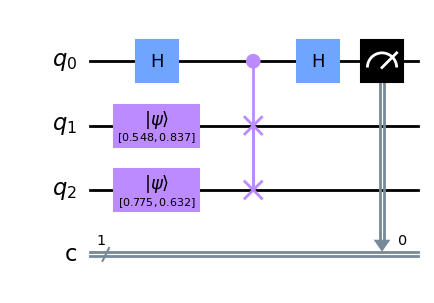

In [9]:

statvector1A = [0.3**0.5,0.7**0.5]
statevector1B = [0.6**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector1A),2))
qc = createCircuit(statvector1A,statevector1B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [10]:

depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector1A,statevector1B)
print("SWAP TEST OVERLAP: ", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP:  0.92
OVERLAP found mathematically: 0.908998886412873
SWAP TEST works correctly


## 2nd Ques

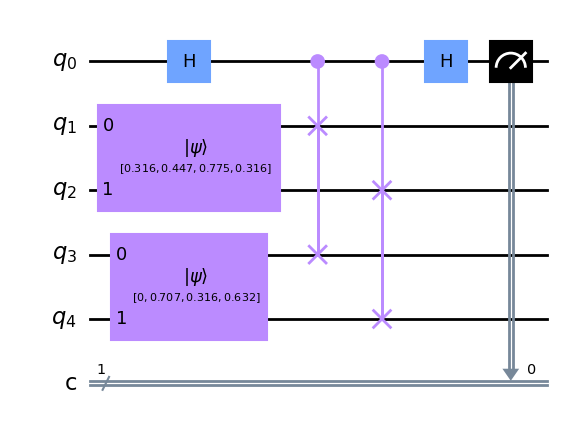

In [11]:

statvector2A = [0.1**0.5, 0.2**0.5, 0.6**0.5,0.1**0.5]
statevector2B = [0.0**0.5,0.5**0.5, 0.1**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector2A),2))
qc = createCircuit(statvector2A,statevector2B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [12]:
depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector2A,statevector2B)
print("SWAP TEST OVERLAP:", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP: 0.603
OVERLAP found mathematically: 0.5793900299663589
SWAP TEST does not agree with mathematical overlap


## 3rd Ques

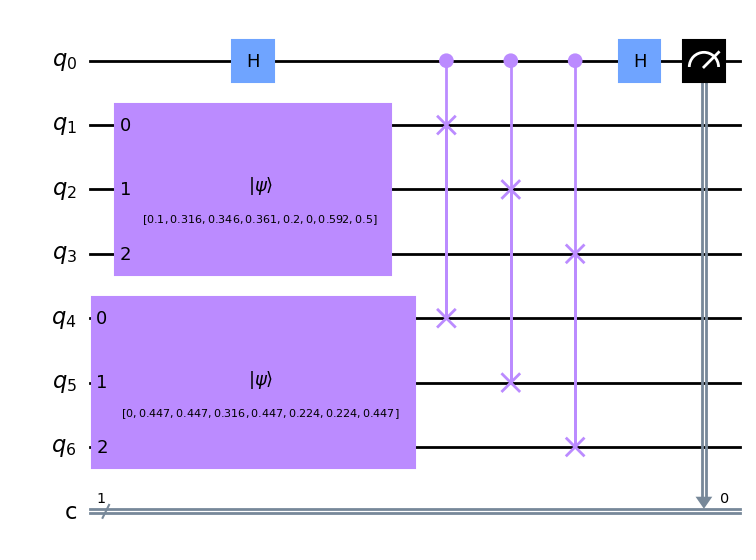

In [13]:

statvector3A = [0.01**0.5, 0.1**0.5, 0.12**0.5,0.13**0.5,0.04**0.5,0,0.35**0.5,0.25**0.5]
statevector3B = [0.00**0.5, 0.2**0.5, 0.2**0.5,0.1**0.5,0.2**0.5,0.05**0.5,0.05**0.5,0.2**0.5]
no_of_qubits = int(math.log(len(statvector3A),2))
qc = createCircuit(statvector3A,statevector3B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [14]:
depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector3A,statevector3B)
print("SWAP TEST OVERLAP: ", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP:  0.749
OVERLAP found mathematically: 0.7322144721107586
SWAP TEST works correctly


<span style="color:grey; font-size:18px">**Looking at the above 3 results, we can confirm that SWAP TEST is working properly as the values got mathematically do not differ much from the values using the test**</span>

# <span style="color:purple">**Simulating SWAP TEST with Depolarizing Noise**</span>

## 1st Ques

In [15]:
statvector1A = [0.3**0.5,0.7**0.5]
statevector1B = [0.6**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector1A),2))
qc = createCircuit(statvector1A,statevector1B, no_of_qubits)

In [16]:
depolarNoise = 0
stepSize = 0.01
ques_1_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_1_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)  


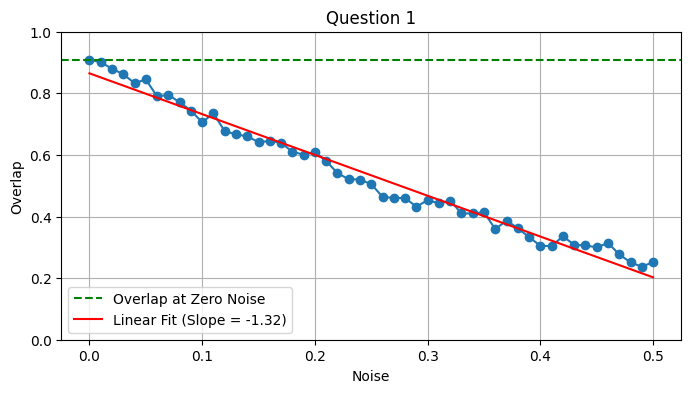

In [17]:
plot_noiseVsOverlap(ques_1_noiseVsOverlap, "Question 1")

## 2nd Ques

In [18]:

statvector2A = [0.1**0.5, 0.2**0.5, 0.6**0.5,0.1**0.5]
statevector2B = [0.0**0.5,0.5**0.5, 0.1**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector2A),2))
qc = createCircuit(statvector2A,statevector2B, no_of_qubits)


In [19]:
depolarNoise = 0
stepSize = 0.01
ques_2_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_2_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)

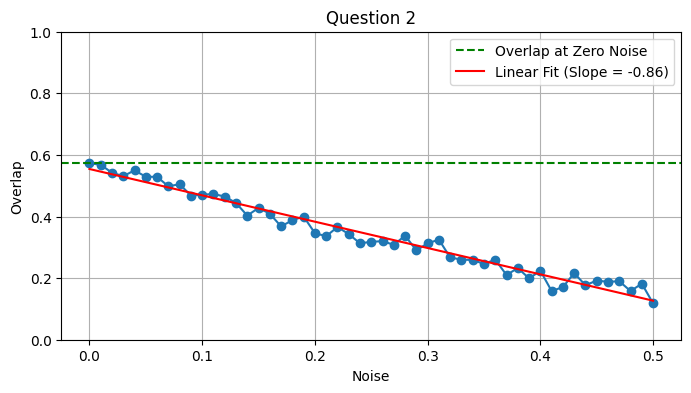

In [20]:
plot_noiseVsOverlap(ques_2_noiseVsOverlap, "Question 2")

## 3rd Ques

In [21]:

statvector3A = [0.01**0.5, 0.1**0.5, 0.12**0.5,0.13**0.5,0.04**0.5,0,0.35**0.5,0.25**0.5]
statevector3B = [0.00**0.5, 0.2**0.5, 0.2**0.5,0.1**0.5,0.2**0.5,0.05**0.5,0.05**0.5,0.2**0.5]
no_of_qubits = int(math.log(len(statvector3A),2))
qc = createCircuit(statvector3A,statevector3B, no_of_qubits)


In [22]:
depolarNoise = 0
stepSize = 0.01
ques_3_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_3_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)

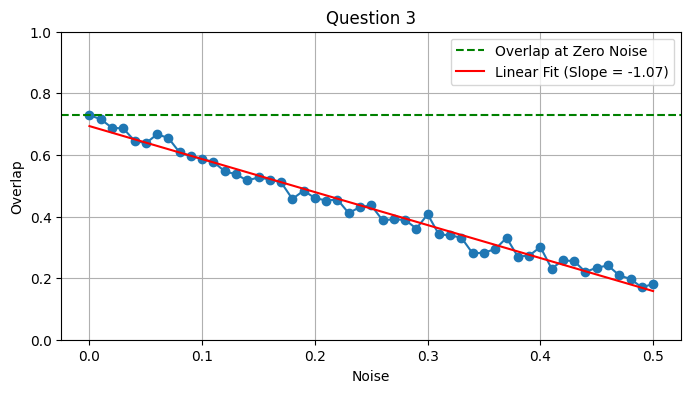

In [23]:
plot_noiseVsOverlap(ques_3_noiseVsOverlap, "Question 3")

# **OBSERVATIONS ON NOISE vs OVERLAP GRAPH WITH NO MITIGATION DONE**

* The depolarizing noise causes the overlap to always reduce linearly.

<span style="color:grey; font-size:18px">**Using error mtitigation techniques may help in getting the linear fit line closer to the line that goes through the overlap at 0 noise**</span>

# <span style="color:purple">**Simulating SWAP TEST with Depolarizing Noise and use ZNE mitigation technique**</span>

In [24]:
def my_custom_folding_function(statevector_A, statevector_B, folding_list) -> cirq.Circuit:
    no_of_qubits = int(math.log(len(statevector_A),2))
    compose_list = []
    # Create a quantum circuit with three qubits (A, B, and C)
    c = ClassicalRegister(1,'c') #classical Register
    q = QuantumRegister(2*no_of_qubits + 1,'q')
    qc1 = QuantumCircuit(q, c)


    # Apply Hadamard to ancillas
    #for i in range(no_of_qubits):
    qc1.h(q[0])  
    
    # Initialize quantum states A and B
    qc1.initialize(statevector_A, q[1:no_of_qubits+1])
    qc1.initialize(statevector_B, q[no_of_qubits+1:2*no_of_qubits+1])

    qc2 = QuantumCircuit(q, c)
    # Implement the controlled-Swap (CSwap) gate
    for i in range(no_of_qubits):
        qc2.cswap(q[0], q[i + 1], q[i+1+no_of_qubits])

    for i in range(2*no_of_qubits+1):
        compose_list.append(i)
    
    
    # Apply inverse Hadamard gates
    qc2.h(0)  
    
    # Measure the ancilla qubit C
    #for i in range(no_of_qubits):
    qc2.measure(q[0],c[0])

    #fold required layers
    qc_fin = layer_folding(qc2, folding_list)
    merged_circuit = qc1.compose(qc_fin, qubits=compose_list, front=False)
    
    return merged_circuit

## Ques 1

In [27]:
statevector_A = [0.3**0.5,0.7**0.5]
statevector_B = [0.6**0.5,0.4**0.5]
# Choose a list of scale factors
folding_list_set = [[10**x+25,x+25] for x in range(5)]

scale_factors = [float(x) for x in range(5)]
# Generate a list of folded circuits
noise_scaled_circuits = [my_custom_folding_function(statevector_A,statevector_B, s) for s in folding_list_set]

In [28]:
depolarNoise = 0
stepSize = 0.01
stepSize2 = 0.05
ques_1_noiseVsOverlap_mit = {}


while depolarNoise <= 0.5:
    expectation_values = [swapTest(circ) for circ in noise_scaled_circuits]
        # Initialize a factory
    fac = zne.inference.LinearFactory(scale_factors)
    # Load data:
    for s, e in zip(scale_factors, expectation_values):
        fac.push({"scale_factor": s}, e)
    
    # Evaluate the extrapolation
    final_exp = fac.reduce()
    ques_1_noiseVsOverlap_mit[depolarNoise] = final_exp
    if depolarNoise >= 0.01:
        depolarNoise = round(depolarNoise + stepSize2, 2)  
    else:
        depolarNoise = round(depolarNoise + stepSize, 2)  

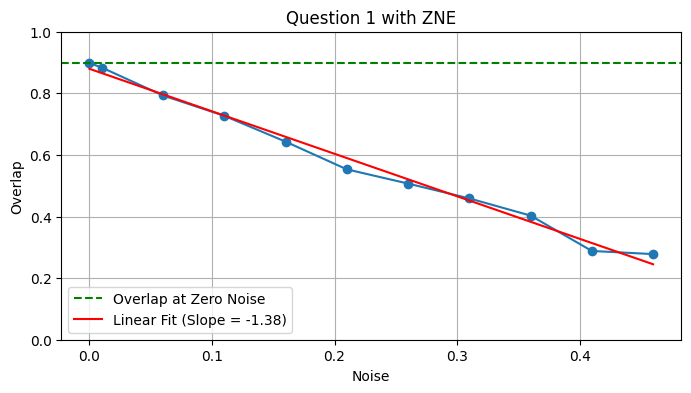

In [29]:
plot_noiseVsOverlap(ques_1_noiseVsOverlap_mit, "Question 1 with ZNE")

## Ques 2

In [30]:
statvector2A = [0.1**0.5, 0.2**0.5, 0.6**0.5,0.1**0.5]
statevector2B = [0.0**0.5,0.5**0.5, 0.1**0.5,0.4**0.5]
# Choose a list of scale factors
folding_list_set = [[10**x+25,10**x+25,x+25] for x in range(5)]

scale_factors = [float(x) for x in range(5)]
# Generate a list of folded circuits
noise_scaled_circuits = [my_custom_folding_function(statvector2A,statevector2B, s) for s in folding_list_set]

In [31]:
depolarNoise = 0
stepSize = 0.01
stepSize2 = 0.05
ques_2_noiseVsOverlap_mit = {}

while depolarNoise <= 0.5:
    expectation_values = [swapTest(circ) for circ in noise_scaled_circuits]
        # Initialize a factory
    fac = zne.inference.LinearFactory(scale_factors)
    # Load data:
    for s, e in zip(scale_factors, expectation_values):
        fac.push({"scale_factor": s}, e)
    
    # Evaluate the extrapolation
    final_exp = fac.reduce()
    ques_2_noiseVsOverlap_mit[depolarNoise] = final_exp
    if depolarNoise >= 0.01:
        depolarNoise = round(depolarNoise + stepSize2, 2)  
    else:
        depolarNoise = round(depolarNoise + stepSize, 2)  

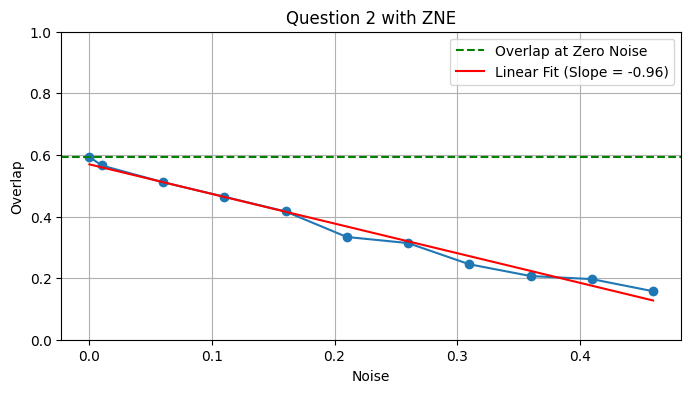

In [32]:
plot_noiseVsOverlap(ques_2_noiseVsOverlap_mit, "Question 2 with ZNE")

## Ques 3

In [33]:
statvector3A = [0.01**0.5, 0.1**0.5, 0.12**0.5,0.13**0.5,0.04**0.5,0,0.35**0.5,0.25**0.5]
statevector3B = [0.00**0.5, 0.2**0.5, 0.2**0.5,0.1**0.5,0.2**0.5,0.05**0.5,0.05**0.5,0.2**0.5]
# Choose a list of scale factors
folding_list_set = [[10**x+25,10**x+25,10**x+25,x+25] for x in range(5)]

scale_factors = [float(x) for x in range(5)]
# Generate a list of folded circuits
noise_scaled_circuits = [my_custom_folding_function(statvector3A,statevector3B, s) for s in folding_list_set]

In [34]:
depolarNoise = 0
stepSize = 0.01
stepSize2 = 0.05
ques_3_noiseVsOverlap_mit = {}

while depolarNoise <= 0.5:
    expectation_values = [swapTest(circ) for circ in noise_scaled_circuits]
        # Initialize a factory
    fac = zne.inference.LinearFactory(scale_factors)
    # Load data:
    for s, e in zip(scale_factors, expectation_values):
        fac.push({"scale_factor": s}, e)
    
    # Evaluate the extrapolation
    final_exp = fac.reduce()
    ques_3_noiseVsOverlap_mit[depolarNoise] = final_exp
    if depolarNoise >= 0.01:
        depolarNoise = round(depolarNoise + stepSize2, 2)  
    else:
        depolarNoise = round(depolarNoise + stepSize, 2)  
    

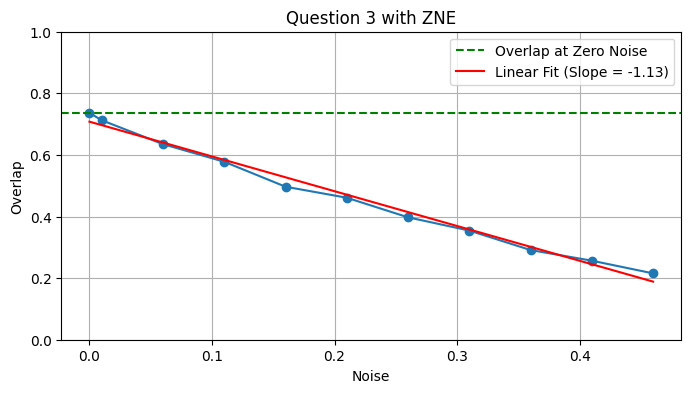

In [35]:
plot_noiseVsOverlap(ques_3_noiseVsOverlap_mit, "Question 3 with ZNE")

<span style="color:grey; font-size:18px">**We see That ZNE in its current settings did not help to reduce the slope of the fitting line.
Using a different technique such as PEC (Probabilistic error cancelation technique) or using a different setting for folding the circuits may help.
Due to time constraint other models could not be tried**</span>